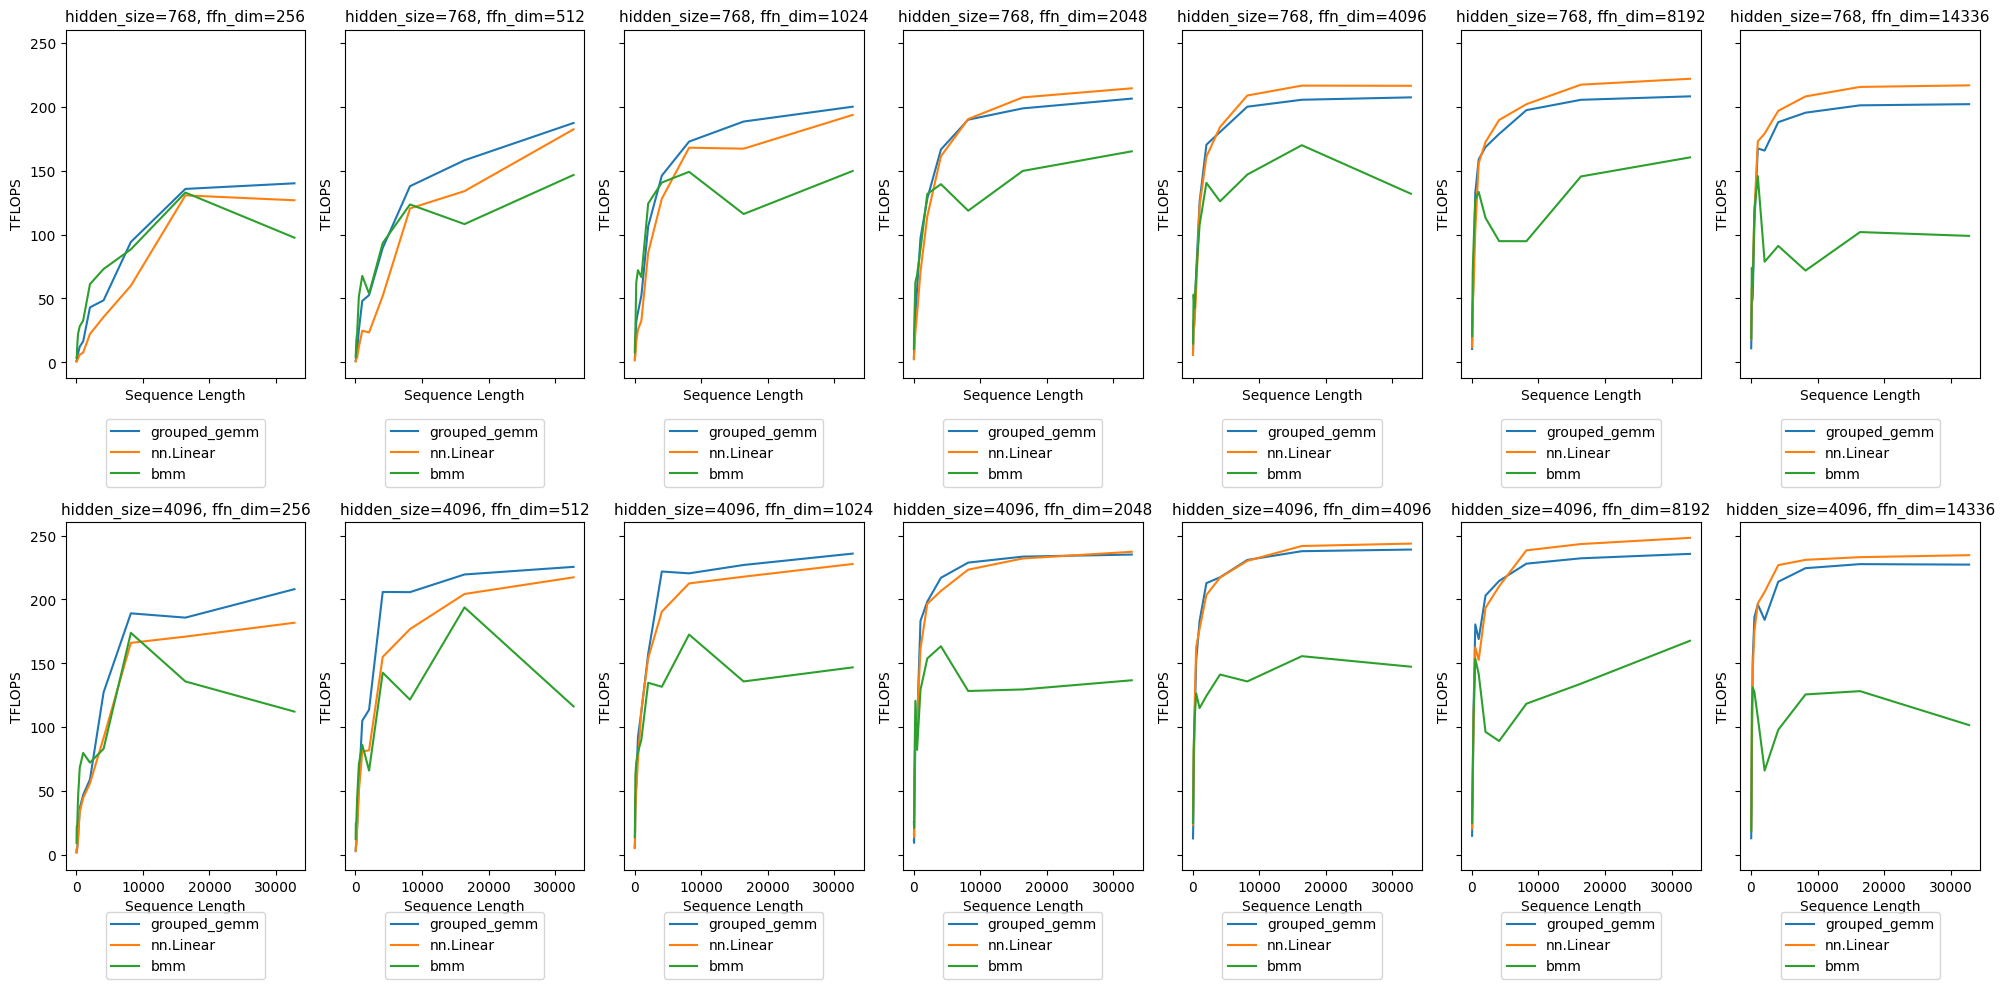

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Read the data file
with open('perf.txt', 'r') as file:
    data = file.read()

parts = data.split('-' * 50)

batch_sizes = [1]
sequence_lengths = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
hidden_sizes = [768, 4096]
ffn_dims = [256, 512, 1024, 2048, 4096, 8192, 14336]

grouped_gemm_tflops = {}
nn_linear_tflops = {}
bmm_tflops = {}

# Traverse each part and extract the relevant information
for part in parts:
    lines = part.strip().split('\n')
    if len(lines) < 10:
        continue
    
    params = lines[0].split(':')[1].split(',')
    batch_size = int(params[0].split('=')[1])
    sequence_length = int(params[1].split('=')[1])
    hidden_size = int(params[2].split('=')[1])
    ffn_dim = int(params[3].split('=')[1])
    
    if (batch_size, hidden_size, ffn_dim) not in grouped_gemm_tflops:
        grouped_gemm_tflops[(batch_size, hidden_size, ffn_dim)] = []
        nn_linear_tflops[(batch_size, hidden_size, ffn_dim)] = []
        bmm_tflops[(batch_size, hidden_size, ffn_dim)] = []
    
    for line in lines:
        if 'TFLOPS (grouped_gemm):' in line:
            grouped_gemm_tflops[(batch_size, hidden_size, ffn_dim)].append(float(line.split(':')[1]))
        elif 'TFLOPS (nn.Linear):' in line:
            nn_linear_tflops[(batch_size, hidden_size, ffn_dim)].append(float(line.split(':')[1]))
        elif 'TFLOPS (bmm):' in line:
            bmm_tflops[(batch_size, hidden_size, ffn_dim)].append(float(line.split(':')[1]))

# Create subplots for each parameter combination
fig, axs = plt.subplots(len(hidden_sizes), len(ffn_dims), figsize=(20, 10), sharex=True, sharey=True)

for i, hidden_size in enumerate(hidden_sizes):
    for j, ffn_dim in enumerate(ffn_dims):
        ax = axs[i, j]
        
        for batch_size in batch_sizes:
            key = (batch_size, hidden_size, ffn_dim)
            if key in grouped_gemm_tflops:
                ax.plot(sequence_lengths[:len(grouped_gemm_tflops[key])], grouped_gemm_tflops[key], label=f'grouped_gemm')
                ax.plot(sequence_lengths[:len(nn_linear_tflops[key])], nn_linear_tflops[key], label=f'nn.Linear')
                ax.plot(sequence_lengths[:len(bmm_tflops[key])], bmm_tflops[key], label=f'bmm')
        
        ax.set_title(f'hidden_size={hidden_size}, ffn_dim={ffn_dim}', fontsize=11)
        ax.set_xlabel('Sequence Length')
        ax.set_ylabel('TFLOPS')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()